<a href="https://colab.research.google.com/github/curiosity806/machine-learning-and-practice-report/blob/master/Dacon_satellite_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# 훈련 데이터
!cp '/content/drive/My Drive/2020 Kaggle Study/data/train_final.npy' train.npy

In [3]:
import numpy as np

train = np.load('train.npy')

In [5]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import random
import warnings
import gc
import matplotlib.pyplot as plt


from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

warnings.filterwarnings("ignore")

# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
#tf.random.set_seed(7)

# 모델링

In [7]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_true = y_true.reshape(1, -1)[0]  
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1, -1)[0]
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

X = train[:,:14]
y = train[:,-1]
X.shape, y.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Standard Scaling한 데이터 생성

In [8]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_normalized.shape

(9347, 14)

## 선형회귀

1. 모형의 선형성: 모든 예측값에서 잔차가 비슷하게 있어야 함
2. 잔차의 정규성:Q-Q Plot
3. 잔차의 등분산성
4. 잔차의 독립성

기본 가정을 만족하지 않는다면 stepwise로 4가지 기본 가정을 위배시키는 변수를 제거

<interesting 합니다.>

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    lr = LinearRegression(normalize = False)
    lr.fit(X_train[train_index], y_train[train_index])
    pred = lr.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

LR_cv_mae = np.mean(scores)
print('LinearRegression, normalize = False')
print(f'단순 선형 회귀 cv_mae_score = {LR_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    lr = LinearRegression(normalize = True)
    lr.fit(X_train[train_index], y_train[train_index])
    pred = lr.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))
    
LR_normal_cv_mae = np.mean(scores)
print('LinearRegression, normalize = True')
print(f'단순 선형 회귀 cv_mae_score = {LR_normal_cv_mae}\n')

LinearRegression, normalize = False
단순 선형 회귀 cv_mae_score = 17.440942764282227

LinearRegression, normalize = True
단순 선형 회귀 cv_mae_score = 17.44093894958496



## 다항회귀

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # 선형회귀 모델 훈련
    lr = LinearRegression(normalize = False)
    lr.fit(features_interaction, y_train[train_index])
    pred = lr.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_LR_cv_mae = np.mean(scores)
print('Poly_LR_cv_mae, degree  = 3,  normalize = False')
print(f'Poly_LR_cv_mae = {Poly_LR_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # 선형회귀 모델 훈련
    lr = LinearRegression(normalize = True)
    lr.fit(features_interaction, y_train[train_index])
    pred = lr.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_LR_normal_cv_mae = np.mean(scores)
print('Poly_LR_normal_cv_mae, degree  = 3,  normalize = True')
print(f'Poly_LR_normal_cv_mae = {Poly_LR_normal_cv_mae}\n')

Poly_LR_cv_mae, degree  = 3,  normalize = False
Poly_LR_cv_mae = 17.9493408203125

Poly_LR_normal_cv_mae, degree  = 3,  normalize = True
Poly_LR_normal_cv_mae = 17.74848747253418



### 릿지 다항 회귀

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    Ridge_model = Ridge(normalize = False, alpha = 0.1)
    Ridge_model.fit(features_interaction, y_train[train_index])
    pred = Ridge_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_Ridge_cv_mae = np.mean(scores)
print('Poly_Ridge_cv_mae, degree  = 3,  normalize = False')
print(f'Poly_Ridge_cv_mae = {Poly_Ridge_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    Ridge_model = Ridge(normalize = True, alpha = 0.1)
    Ridge_model.fit(features_interaction, y_train[train_index])
    pred = Ridge_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_Ridge_normal_cv_mae = np.mean(scores)
print('Poly_Ridge_normal_cv_mae, degree  = 3,  normalize = True')
print(f'Poly_Ridge_normal_cv_mae = {Poly_Ridge_normal_cv_mae}\n')

Poly_Ridge_cv_mae, degree  = 3,  normalize = False
Poly_Ridge_cv_mae = 19.5375919342041

Poly_Ridge_normal_cv_mae, degree  = 3,  normalize = True
Poly_Ridge_normal_cv_mae = 17.378116607666016



### 라쏘 다항회귀

In [ ]:
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    Lasso_model = Lasso(normalize = False, alpha = 0.1)
    Lasso_model.fit(features_interaction, y_train[train_index])
    pred = Lasso_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_Lasso_cv_mae = np.mean(scores)
print('Poly_Lasso_cv_mae, degree  = 3,  normalize = False')
print(f'Poly_Lasso_cv_mae = {Poly_Lasso_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    Lasso_model = Lasso(normalize = True, alpha = 0.1)
    Lasso_model.fit(features_interaction, y_train[train_index])
    pred = Lasso_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_Lasso_normal_cv_mae = np.mean(scores)
print('Poly_Lasso_normal_cv_mae, degree  = 3,  normalize = True')
print(f'Poly_Lasso_normal_cv_mae = {Poly_Lasso_normal_cv_mae}\n')

Poly_Lasso_cv_mae, degree  = 3,  normalize = False
Poly_Lasso_cv_mae = 17.245738983154297

Poly_Lasso_normal_cv_mae, degree  = 3,  normalize = True
Poly_Lasso_normal_cv_mae = 18.111082077026367



### 엘라스틱 다항회귀

In [ ]:
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    ElasticNet_model = ElasticNet(normalize = False, alpha = 0.1)
    ElasticNet_model.fit(features_interaction, y_train[train_index])
    pred = ElasticNet_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_ElasticNet_cv_mae = np.mean(scores)
print('Poly_ElasticNet_cv_mae, degree  = 3,  normalize = False')
print(f'Poly_ElasticNet_cv_mae = {Poly_ElasticNet_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    ElasticNet_model = ElasticNet(normalize = True, alpha = 0.1)
    ElasticNet_model.fit(features_interaction, y_train[train_index])
    pred = ElasticNet_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_ElasticNet_normal_cv_mae = np.mean(scores)
print('Poly_ElasticNet_normal_cv_mae, degree  = 3,  normalize = True')
print(f'Poly_ElasticNet_normal_cv_mae = {Poly_ElasticNet_normal_cv_mae}\n')

Poly_ElasticNet_cv_mae, degree  = 3,  normalize = False
Poly_ElasticNet_cv_mae = 17.245868682861328

Poly_ElasticNet_normal_cv_mae, degree  = 3,  normalize = True
Poly_ElasticNet_normal_cv_mae = 18.111082077026367



## SVM

### 1차 그리드 서치

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR


def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_true = y_true.reshape(1, -1)[0]  
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1, -1)[0]
    mae = np.mean(np.abs(y_true - y_pred))
    return mae


param_grid = {'C': [0.1,1,10], 'kernel': ['rbf', 'poly', 'sigmoid']}
grid_svr = GridSearchCV(SVR(),
                        param_grid,
                        refit=True,
                        scoring = make_scorer(mae, greater_is_better=False),
                        verbose=2)

grid_svr.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ C=0.1, kernel=rbf, total=   4.3s
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] ................................ C=0.1, kernel=rbf, total=   4.2s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   4.2s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   4.2s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   4.2s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   2.8s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   2.8s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   2.8s
[CV] C=0.1, kernel=poly ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae, greater_is_better=False), verbose=2)

In [ ]:
# best parameter 적용
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    svr = SVR(C = grid_svr.best_params_['C'],
              kernel = grid_svr.best_params_['kernel'],
              verbose = True)
    svr.fit(X_train[train_index], y_train[train_index])
    pred = svr.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

SVR_cv_mae = np.mean(scores)
print('\nSVR, C = {0}, kernel = {1}'.format(grid_svr.best_params_['C'], grid_svr.best_params_['kernel']))
print(f'SVR cv_mae_score = {SVR_cv_mae}\n')

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
SVR, C = 10, kernel = poly
SVR cv_mae_score = 15.837368932183818



In [ ]:
grid_svr.cv_results_['params']

[{'C': 0.1, 'kernel': 'rbf'},
 {'C': 0.1, 'kernel': 'poly'},
 {'C': 0.1, 'kernel': 'sigmoid'},
 {'C': 1, 'kernel': 'rbf'},
 {'C': 1, 'kernel': 'poly'},
 {'C': 1, 'kernel': 'sigmoid'},
 {'C': 10, 'kernel': 'rbf'},
 {'C': 10, 'kernel': 'poly'},
 {'C': 10, 'kernel': 'sigmoid'}]

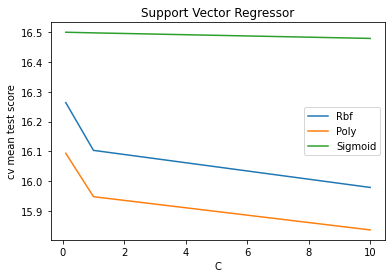

In [ ]:
plt.plot([0.1,1,10], -grid_svr.cv_results_['mean_test_score'][[0,3,6]], label='Rbf')
plt.plot([0.1,1,10], -grid_svr.cv_results_['mean_test_score'][[1,4,7]], label='Poly')
plt.plot([0.1,1,10], -grid_svr.cv_results_['mean_test_score'][[2,5,8]], label='Sigmoid')
plt.legend()
plt.title('Support Vector Regressor')
plt.xlabel('C')
plt.ylabel('cv mean test score')
plt.show()

### 2차 그리드 서치

In [11]:
param_grid = {'C': range(10,31), 'kernel': ['poly']}
grid_svr = GridSearchCV(SVR(),
                        param_grid,
                        refit=True,
                        scoring = make_scorer(mae, greater_is_better=False),
                        verbose=2)
grid_svr.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] C=10, kernel=poly ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ C=10, kernel=poly, total=   4.2s
[CV] C=10, kernel=poly ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] ................................ C=10, kernel=poly, total=   4.0s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   4.0s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   4.1s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   4.0s
[CV] C=11, kernel=poly ...............................................
[CV] ................................ C=11, kernel=poly, total=   4.0s
[CV] C=11, kernel=poly ...............................................
[CV] ................................ C=11, kernel=poly, total=   4.2s
[CV] C=11, kernel=poly ...............................................
[CV] ................................ C=11, kernel=poly, total=   4.0s
[CV] C=11, kernel=poly ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  7.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': range(10, 31), 'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae, greater_is_better=False), verbose=2)

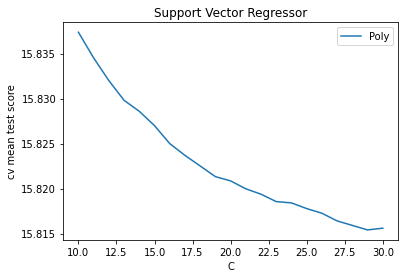

In [12]:
plt.plot(range(10,31), - grid_svr.cv_results_['mean_test_score'], label='Poly')
plt.legend()
plt.title('Support Vector Regressor')
plt.xlabel('C')
plt.ylabel('cv mean test score')
plt.show()

In [13]:
print(f'best_score : {-grid_svr.best_score_}')
grid_svr.best_estimator_

best_score : 15.815398319162949


SVR(C=29, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### SVM normalize

In [15]:
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train_normalized):
    best_svr = grid_svr.best_estimator_
    best_svr.fit(X_train_normalized[train_index], y_train[train_index])
    pred = best_svr.predict(X_train_normalized[test_index])
    scores.append(mae(y_train[test_index], pred))

SVR_cv_mae = np.mean(scores)
print('\nSVR, C = {0}, kernel = {1}'.format(grid_svr.best_params_['C'], grid_svr.best_params_['kernel']))
print(f'SVR cv_mae_score = {SVR_cv_mae}\n')


SVR, C = 29, kernel = poly
SVR cv_mae_score = 16.051933968245066



## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer





param_grid = {'max_depth' : range(2,8)}


gs_tree = GridSearchCV(DecisionTreeRegressor(criterion = 'mse'),
                       param_grid,
                       refit=True,
                       scoring = make_scorer(mae, greater_is_better=False),
                       verbose=2)
gs_tree.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=3, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(2, 8)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring=mak

In [ ]:
# best parameter 적용
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    tree = DecisionTreeRegressor(max_depth = gs_tree.best_params_['max_depth'])
    tree.fit(X_train[train_index], y_train[train_index])
    pred = tree.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

Decision_Tree_cv_mae = np.mean(scores)
print('Decision Tree Regressor, max_depth = {}'.format(gs_tree.best_params_['max_depth']))
print(f'Decision Tree Regressor cv_mae_score = {Decision_Tree_cv_mae}\n')

Decision Tree Regressor, max_depth = 4
Decision Tree Regressor cv_mae_score = 17.573361979662952



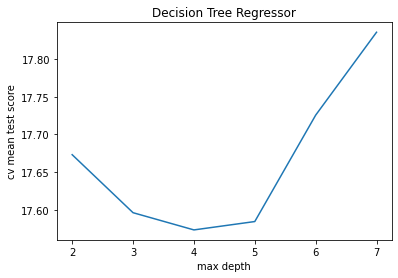

In [ ]:
plt.plot(range(2,8), -gs_tree.cv_results_['mean_test_score'])
plt.title('Decision Tree Regressor')
plt.xlabel('max depth')
plt.ylabel('cv mean test score')
plt.show()

In [ ]:
#normalization 적용
# best parameter 적용
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train_normalized):
    tree = gs_tree.best_estimator_
    tree.fit(X_train_normalized[train_index], y_train[train_index])
    pred = tree.predict(X_train_normalized[test_index])
    scores.append(mae(y_train[test_index], pred))

Decision_Tree_cv_mae = np.mean(scores)
print('Decision Tree Regressor, max_depth = {}'.format(gs_tree.best_params_['max_depth']))
print(f'Decision Tree Regressor cv_mae_score = {Decision_Tree_cv_mae}\n')

Decision Tree Regressor, max_depth = 4
Decision Tree Regressor cv_mae_score = 17.573361979662952



## Random Forest
배깅을 적용한 decision tree의 앙상블

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def negative_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_true = y_true.reshape(1, -1)[0]  
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1, -1)[0]
    mae = np.mean(np.abs(y_true - y_pred))
    return -mae


param_grid = {'max_depth' : range(2,15)}
gs_rf = GridSearchCV(RandomForestRegressor(),
                       param_grid,
                       refit=True,
                       scoring = make_scorer(mae, greater_is_better=False),
                       verbose=2)
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... max_depth=2, total=   1.4s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   1.4s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.3s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.3s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.3s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   1.9s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   1.9s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   1.9s
[CV] max_depth=3 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  4.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [ ]:
# best parameter 적용
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    rf = RandomForestRegressor(max_depth = gs_rf.best_params_['max_depth'])
    rf.fit(X_train[train_index], y_train[train_index])
    pred = rf.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

Random_Forest_cv_mae = np.mean(scores)
print('Random Forest Regressor, max_depth = {}'.format(gs_rf.best_params_['max_depth']))
print(f'Random Forest Regressor cv_mae_score = {Random_Forest_cv_mae}\n')

Random Forest Regressor, max_depth = 10
Random Forest Regressor cv_mae_score = 17.191883948135633



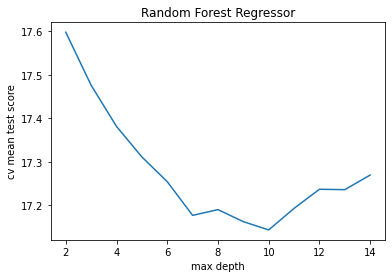

In [ ]:
plt.plot(range(2,15), - gs_rf.cv_results_['mean_test_score'])
plt.title('Random Forest Regressor')
plt.xlabel('max depth')
plt.ylabel('cv mean test score')
plt.show()

In [ ]:
# best parameter 적용
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train_normalized):
    rf = gs_rf.best_estimator_
    rf.fit(X_train_normalized[train_index], y_train[train_index])
    pred = rf.predict(X_train_normalized[test_index])
    scores.append(mae(y_train[test_index], pred))

Random_Forest_cv_mae = np.mean(scores)
print('Random Forest Regressor, max_depth = {}'.format(gs_rf.best_params_['max_depth']))
print(f'Random Forest Regressor cv_mae_score = {Random_Forest_cv_mae}\n')

Random Forest Regressor, max_depth = 10
Random Forest Regressor cv_mae_score = 17.177090103895743



feature importance

In [ ]:
# feature_importance: 가장 중요한 feature 인덱스 순으로 정렬
rf.fit(X_train, y_train)
fi = rf.feature_importances_.tolist()
fi_sort = sorted(fi, reverse=True)



feature_importance = []
for i in range(14):
    feature_importance.append(fi.index(fi_sort[i]))
print('feature_importance : ',feature_importance)
# 중요도 높은 feature 순서대로 선택하여 훈련
cv_mae_selected = []
for i in range(1,15):
    X_train_selected = X_train[:,feature_importance[:i]]
    kf = KFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(X_train_selected):
        rf = RandomForestRegressor(max_depth = gs_rf.best_params_['max_depth'])
        rf.fit(X_train_selected[train_index], y_train[train_index])
        pred = rf.predict(X_train_selected[test_index])
        scores.append(mae(y_train[test_index], pred))
    cv_mae = np.mean(scores)
    cv_mae_selected.append(cv_mae)
    print(i, 'fold')

1 fold
2 fold
3 fold
4 fold
5 fold
6 fold
7 fold
8 fold
9 fold
10 fold
11 fold
12 fold
13 fold
14 fold


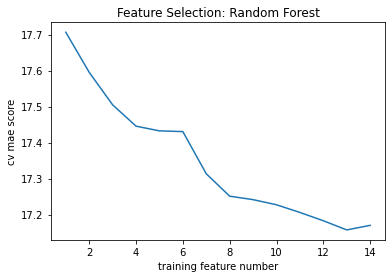

In [ ]:
# feature selection 시각화
plt.plot(range(1,15), cv_mae_selected)
plt.title('Feature Selection: Random Forest')
plt.xlabel('training feature number')
plt.ylabel('cv mae score')
plt.show()

## Gradient Boosting Regressor
부스팅을 적용한 decision tree의 앙상블

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {'max_depth': range(2,10),
              'learning_rate': [0.05, .1]}
gs_gbr = GridSearchCV(GradientBoostingRegressor(),
                      param_grid,
                      refit=True,
                       scoring = make_scorer(mae, greater_is_better=False),
                       verbose=2)
gs_gbr.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] learning_rate=0.05, max_depth=2 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. learning_rate=0.05, max_depth=2, total=   2.2s
[CV] learning_rate=0.05, max_depth=2 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] .................. learning_rate=0.05, max_depth=2, total=   2.2s
[CV] learning_rate=0.05, max_depth=2 .................................
[CV] .................. learning_rate=0.05, max_depth=2, total=   2.1s
[CV] learning_rate=0.05, max_depth=2 .................................
[CV] .................. learning_rate=0.05, max_depth=2, total=   2.1s
[CV] learning_rate=0.05, max_depth=2 .................................
[CV] .................. learning_rate=0.05, max_depth=2, total=   2.1s
[CV] learning_rate=0.05, max_depth=3 .................................
[CV] .................. learning_rate=0.05, max_depth=3, total=   3.1s
[CV] learning_rate=0.05, max_depth=3 .................................
[CV] .................. learning_rate=0.05, max_depth=3, total=   3.1s
[CV] learning_rate=0.05, max_depth=3 .................................
[CV] .................. learning_rate=0.05, max_depth=3, total=   3.1s
[CV] learning_rate=0.05, max_depth=3 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  7.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
              

In [ ]:
# best parameter 적용

kf = KFold(n_splits=5)
scores = []

for train_index, test_index in kf.split(X_train):
    gbr = GradientBoostingRegressor(max_depth = gs_gbr.best_params_['max_depth'], learning_rate = gs_gbr.best_params_['learning_rate'])
    gbr.fit(X_train[train_index], y_train[train_index])
    pred = gbr.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

GBR_cv_mae = np.mean(scores)
print('Gradient Boosting Regressor, max_depth = {0}, learning_rate = {1}'.format(gs_gbr.best_params_['max_depth'], gs_gbr.best_params_['learning_rate']))
print(f'Gradient Boosting Regressor cv_mae_score = {GBR_cv_mae}\n')

Gradient Boosting Regressor, max_depth = 4, learning_rate = 0.1
Gradient Boosting Regressor cv_mae_score = 17.271155098545016



In [ ]:
gs_gbr.cv_results_

{'mean_fit_time': array([2.12826519, 3.1077611 , 4.06154494, 5.0069335 , 5.99009719,
        6.84406705, 7.75559483, 8.64030123, 2.11163206, 3.13011212,
        4.105794  , 5.05854573, 6.01675529, 6.96495166, 7.91209188,
        8.8309412 ]),
 'mean_score_time': array([0.0023571 , 0.00287457, 0.00382924, 0.00427761, 0.00506439,
        0.00599513, 0.00702343, 0.00816445, 0.0020679 , 0.00256653,
        0.00330472, 0.00385585, 0.00460081, 0.00535355, 0.00648355,
        0.00740738]),
 'mean_test_score': array([-17.40891205, -17.32509413, -17.28619111, -17.26929075,
        -17.28321734, -17.26863133, -17.336664  , -17.40826343,
        -17.32935654, -17.2707714 , -17.26715049, -17.33714046,
        -17.39797922, -17.40002239, -17.57096639, -17.63744888]),
 'param_learning_rate': masked_array(data=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.1,
                    0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, False, False, False, False,
       

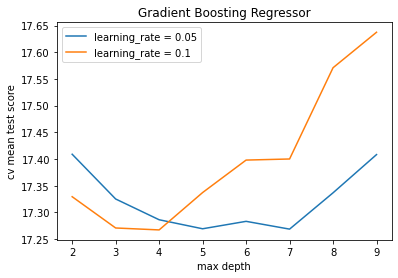

In [ ]:
plt.plot(range(2,10), -gs_gbr.cv_results_['mean_test_score'][:8], label = 'learning_rate = 0.05')
plt.plot(range(2,10), -gs_gbr.cv_results_['mean_test_score'][8:], label = 'learning_rate = 0.1')
plt.legend()

plt.title('Gradient Boosting Regressor')
plt.xlabel('max depth')
plt.ylabel('cv mean test score')
plt.show()

## feature selection

### Random Forest feature selection

### Gradient Boosting feature selection

In [ ]:
# feature_importance: 가장 중요한 feature 인덱스 순으로 정렬
gbr = gs_gbr.best_estimator_
gbr.fit(X_train, y_train)
fi = gbr.feature_importances_.tolist()
fi_sort = sorted(fi, reverse=True)
feature_importance = []
for i in range(14):
    feature_importance.append(fi.index(fi_sort[i]))

# 중요도 높은 feature 순서대로 선택하여 훈련
cv_mae_selected = []
for i in tqdm(range(1,15)): 
    X_train_selected = X_train[:,feature_importance[:i]]
    kf = KFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(X_train_selected):
        gbr = gs_gbr.best_estimator_
        gbr.fit(X_train_selected[train_index], y_train[train_index])
        pred = gbr.predict(X_train_selected[test_index])
        scores.append(mae(y_train[test_index], pred))
        
    cv_mae = np.mean(scores)
    cv_mae_selected.append(cv_mae)
    #print(i, 'fold')

100%|██████████| 14/14 [02:43<00:00, 11.66s/it]


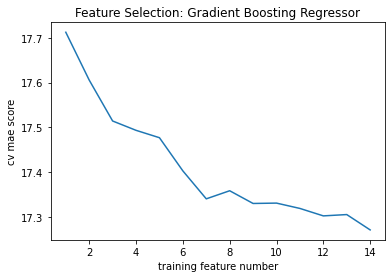

In [ ]:
# feature selection 시각화
plt.plot(range(1,15), cv_mae_selected)
plt.title('Feature Selection: Gradient Boosting Regressor')
plt.xlabel('training feature number')
plt.ylabel('cv mae score')
plt.show()

## XGBoost

### 1차 그리드 서치

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:linear'], # reg:squarederror라고 warning 뜨지만 잘만 돌아감 ㅎㅎ # 열심히 듣긴했는데 사실 별로 안 궁금 ㅎㅎ
              'learning_rate': [.03, 0.05, .1],
              'max_depth': [5, 6, 7, 8, 9, 10],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 3,
                        #n_jobs = 5,
                        scoring = make_scorer(mae, greater_is_better=False),
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train, y_train)
# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.1],
                         'max_depth': [5, 6, 7, 8, 9, 10],
                         'min_child_weight': [4], 'n_estimators': [500],
                         'nthread': [4

In [ ]:
# best parameter 적용
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    xgb = XGBRegressor(learning_rate = xgb_grid.best_params_['learning_rate'],
                       max_depth = xgb_grid.best_params_['max_depth'],
                       verbose = True)
    xgb.fit(X_train[train_index], y_train[train_index])
    pred = xgb.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

XGB_cv_mae = np.mean(scores)
print('XGBoost, learning_rate = {0}, max_depth = {1}'.format(xgb_grid.best_params_['learning_rate'], xgb_grid.best_params_['max_depth']))
print(f'XGBoost cv_mae_score = {XGB_cv_mae}\n')

[13:44:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:44:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:44:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost, learning_rate = 0.03, max_depth = 5
XGBoost cv_mae_score = 16.671968460083008



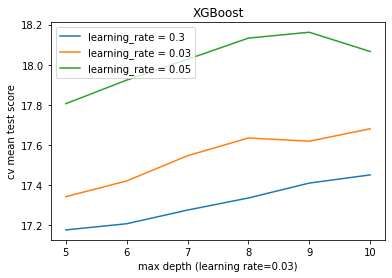

In [ ]:
plt.plot([5, 6, 7, 8, 9, 10], -xgb_grid.cv_results_['mean_test_score'][:6], label='learning_rate = 0.3')
plt.plot([5, 6, 7, 8, 9, 10], -xgb_grid.cv_results_['mean_test_score'][6:12], label='learning_rate = 0.03')
plt.plot([5, 6, 7, 8, 9, 10], -xgb_grid.cv_results_['mean_test_score'][12:18], label='learning_rate = 0.05')

plt.legend()
plt.title('XGBoost')
plt.xlabel('max depth (learning rate={})'.format(xgb_grid.best_params_['learning_rate']))
plt.ylabel('cv mean test score')
plt.show()

### 2차 그리드 서치

In [ ]:
xgb = XGBRegressor()
parameters = {#'nthread':[4],
              #'objective':['reg:linear'], # reg:squarederror라고 warning 뜨지만 잘만 돌아감 ㅎㅎ
              #'learning_rate': [.3],
              'max_depth': range(1,10),
              #'min_child_weight': [4],
              #'silent': [1],
              #'subsample': [0.7],
              #'colsample_bytree': [0.7],
              'n_estimators': [50,100,200]
              }

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 3,
                        learning_rate = 0.3,
                        #n_jobs = 5,
                        scoring = make_scorer(mae, greater_is_better=False),
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train, y_train)
# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

SyntaxError: ignored

In [ ]:
xgb_grid.cv_results_['params']

[{'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 1, 'n_estimators': 200},
 {'max_depth': 2, 'n_estimators': 100},
 {'max_depth': 2, 'n_estimators': 200},
 {'max_depth': 3, 'n_estimators': 100},
 {'max_depth': 3, 'n_estimators': 200},
 {'max_depth': 4, 'n_estimators': 100},
 {'max_depth': 4, 'n_estimators': 200},
 {'max_depth': 5, 'n_estimators': 100},
 {'max_depth': 5, 'n_estimators': 200},
 {'max_depth': 6, 'n_estimators': 100},
 {'max_depth': 6, 'n_estimators': 200},
 {'max_depth': 7, 'n_estimators': 100},
 {'max_depth': 7, 'n_estimators': 200},
 {'max_depth': 8, 'n_estimators': 100},
 {'max_depth': 8, 'n_estimators': 200},
 {'max_depth': 9, 'n_estimators': 100},
 {'max_depth': 9, 'n_estimators': 200}]

In [ ]:
xgb = xgb_grid.best_estimator_
xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
-xgb_grid.best_score_

17.179851531982422

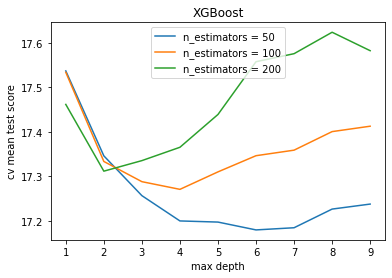

In [ ]:
plt.plot(range(1,10), -xgb_grid.cv_results_['mean_test_score'][range(0,27,3)], label='n_estimators = 50')
plt.plot(range(1,10), -xgb_grid.cv_results_['mean_test_score'][range(1,28,3)], label='n_estimators = 100')
plt.plot(range(1,10), -xgb_grid.cv_results_['mean_test_score'][range(2,29,3)], label='n_estimators = 200')
plt.legend()
plt.title('XGBoost')
plt.xlabel('max depth')
plt.ylabel('cv mean test score')
plt.show()

In [ ]:
# feature_importance: 가장 중요한 feature 인덱스 순으로 정렬
xgb = xgb_grid.best_estimator_

xgb.fit(X_train, y_train)
fi = xgb.feature_importances_.tolist()
fi_sort = sorted(fi, reverse=True)
feature_importance = []
for i in range(14):
    feature_importance.append(fi.index(fi_sort[i]))

# 중요도 높은 feature 순서대로 선택하여 훈련
cv_mae_selected = []
for i in range(1,15): 
    X_train_selected = X_train[:,feature_importance[:i]]
    kf = KFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(X_train_selected):
        xgb = xgb = xgb_grid.best_estimator_
        xgb.fit(X_train_selected[train_index], y_train[train_index])
        pred = xgb.predict(X_train_selected[test_index])
        scores.append(mae(y_train[test_index], pred))
    cv_mae = np.mean(scores)
    cv_mae_selected.append(cv_mae)
    print(i, 'fold')

[14:11:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 fold
[14:11:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favo

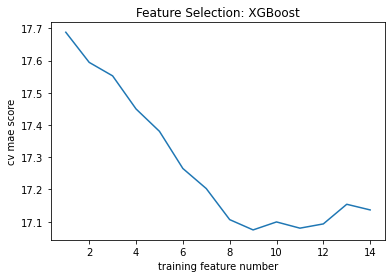

In [ ]:
# feature selection 시각화
plt.plot(range(1,15), cv_mae_selected)
plt.title('Feature Selection: XGBoost')
plt.xlabel('training feature number')
plt.ylabel('cv mae score')
plt.show()

In [ ]:
print('Feature Selection of XGBoost', '\ncv mae score:', min(cv_mae_selected))

Feature Selection of XGBoost 
cv mae score: 17.074438


In [ ]:
print('Feature Selection of XGBoost', '\ncv mae score:', min(cv_mae_selected))

Feature Selection of XGBoost 
cv mae score: 16.715416


## Best Model
- xgboost
- 13개의 feature selection

# PCA

In [ ]:
X_train.shape

(9347, 14)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=14, svd_solver='full')
pc_X_train = pca.fit_transform(X_train)

In [ ]:
pc_X_train_selected.shape

(9347, 14)

In [ ]:
# 중요도 높은 feature 순서대로 선택하여 훈련
cv_mae_selected = []
for i in tqdm(range(14)):
    pc_X_train_selected = pc_X_train[:,:i+1]
    kf = KFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(pc_X_train_selected):
        xgb = xgb_grid.best_estimator_
        xgb.fit(pc_X_train_selected[train_index], y_train[train_index])
        pred = xgb.predict(pc_X_train_selected[test_index])
        scores.append(mae(y_train[test_index], pred))
    cv_mae = np.mean(scores)
    cv_mae_selected.append(cv_mae)
    print(i, 'fold')


  0%|          | 0/14 [00:00<?, ?it/s]

[14:35:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



  7%|▋         | 1/14 [00:00<00:07,  1.71it/s]

[14:35:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0 fold
[14:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



 14%|█▍        | 2/14 [00:01<00:07,  1.51it/s]

1 fold
[14:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



 21%|██▏       | 3/14 [00:02<00:08,  1.26it/s]

2 fold
[14:35:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



 29%|██▊       | 4/14 [00:03<00:09,  1.04it/s]

3 fold
[14:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



 36%|███▌      | 5/14 [00:05<00:10,  1.14s/it]

4 fold
[14:35:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



 43%|████▎     | 6/14 [00:07<00:10,  1.35s/it]

5 fold
[14:35:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



 50%|█████     | 7/14 [00:09<00:10,  1.55s/it]

6 fold
[14:35:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



 57%|█████▋    | 8/14 [00:11<00:10,  1.75s/it]

7 fold
[14:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



 64%|██████▍   | 9/14 [00:13<00:09,  1.95s/it]

8 fold
[14:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



 71%|███████▏  | 10/14 [00:16<00:08,  2.17s/it]

9 fold
[14:35:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



 79%|███████▊  | 11/14 [00:19<00:07,  2.39s/it]

10 fold
[14:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



 86%|████████▌ | 12/14 [00:22<00:05,  2.60s/it]

11 fold
[14:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



 93%|█████████▎| 13/14 [00:25<00:02,  2.80s/it]

12 fold
[14:35:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



100%|██████████| 14/14 [00:29<00:00,  2.10s/it]

13 fold


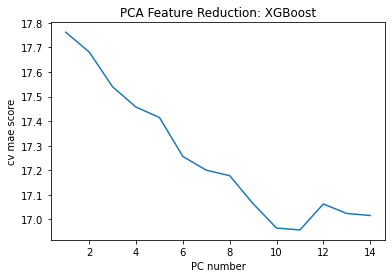

In [ ]:
plt.plot(range(1,15), cv_mae_selected)
plt.title('PCA Feature Reduction: XGBoost')
plt.xlabel('PC number')
plt.ylabel('cv mae score')
plt.show()

In [ ]:
np.min(cv_mae_selected)

16.957409

In [ ]:
cv_mae_selected = []
for i in tqdm(range(14)):
    pc_X_train_selected = pc_X_train[:,:i+1]
    kf = KFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(pc_X_train_selected):
        best_svr = grid_svr.best_estimator_
        best_svr.fit(pc_X_train_selected[train_index], y_train[train_index])
        pred = best_svr.predict(pc_X_train_selected[test_index])
        scores.append(mae(y_train[test_index], pred))
    cv_mae = np.mean(scores)
    cv_mae_selected.append(cv_mae)
    print(f'Score used PC until {i+1}', cv_mae)
    print(i, 'fold')



  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:48<10:26, 48.20s/it]

Score used PC until 1 16.487006663151053
0 fold




 14%|█▍        | 2/14 [01:21<08:43, 43.66s/it]

Score used PC until 2 16.308988747900933
1 fold




 21%|██▏       | 3/14 [01:45<06:56, 37.87s/it]

Score used PC until 3 16.18438056162519
2 fold




 29%|██▊       | 4/14 [02:10<05:38, 33.84s/it]

Score used PC until 4 16.147606702065264
3 fold




 36%|███▌      | 5/14 [02:35<04:43, 31.45s/it]

Score used PC until 5 16.16867153375687
4 fold




 43%|████▎     | 6/14 [03:00<03:55, 29.40s/it]

Score used PC until 6 16.102673478492015
5 fold




 50%|█████     | 7/14 [03:26<03:18, 28.37s/it]

Score used PC until 7 16.0988010085426
6 fold




 57%|█████▋    | 8/14 [03:51<02:44, 27.46s/it]

Score used PC until 8 16.10706753644267
7 fold




 64%|██████▍   | 9/14 [04:18<02:16, 27.33s/it]

Score used PC until 9 16.049945628886185
8 fold




 71%|███████▏  | 10/14 [04:46<01:49, 27.31s/it]

Score used PC until 10 16.034727571018102
9 fold




 79%|███████▊  | 11/14 [05:12<01:21, 27.01s/it]

Score used PC until 11 16.02520110111672
10 fold




 86%|████████▌ | 12/14 [05:39<00:54, 27.11s/it]

Score used PC until 12 16.026179246071766
11 fold




 93%|█████████▎| 13/14 [06:05<00:26, 26.78s/it]

Score used PC until 13 16.026185374788575
12 fold




100%|██████████| 14/14 [06:33<00:00, 28.11s/it]

Score used PC until 14 16.02617310889324
13 fold


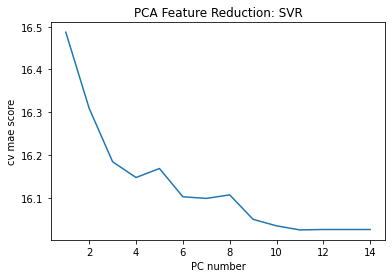

In [ ]:
plt.plot(range(1,15), cv_mae_selected)
plt.title('PCA Feature Reduction: SVR')
plt.xlabel('PC number')
plt.ylabel('cv mae score')
plt.show()

In [ ]:
print(np.min(cv_mae_selected))
print(np.argmin(cv_mae_selected) + 1)

16.02520110111672
11


In [ ]:
-grid_svr.best_score_

15.8213216296203